# Batchnorm

we want hpreact to be roughly around 0 so why not just normalize it?? -> batchnorm

In [37]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [38]:
# read in all the words
words = open('C:/Users/preet/Documents/Keep_Project/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [39]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'

vocab_size = 27

In [40]:
block_size = 3

def build_dataset(words):
    X,Y = [], []
    
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
            
# create sets
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [41]:




n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# MLP
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))


g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)   
# 27x20 matrix -> each letter gets 10 numbers

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 

#the reason we have n_emb * block_size is because we want to concatinate the examples. Instead of a 3x10 matrix for one example
# I want to make it a 1x 30 matrix, each example in one row.


b1 = torch.randn(n_hidden,                        generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# the input into this layer is -> 1X200 
# this weight is 200 x 27 
# the output is 1x 27 vector which would be a probabilty of a letter out of the 27

b2 = torch.randn(vocab_size,                      generator=g) * 0



parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True
    

# at intialization the thing will be exactly unit gausssian


In [42]:
max_steps = 200000
batch_size = 32
lossi = []



for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # its interesting that these are just 32 random example from the dataset. it is possible that some of the examples are not even in the training set???
    
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    # this is embeding each letter to a 1x10 vector
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # remember we what each example to be one row. this makes each example one row
    
    # forward pass:
    hpreact = embcat @ W1 + b1
    
    #Batch-norm
    
    hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True)) + bnbias

    
    
    h = torch.tanh(hpreact) # activation is tanh
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
  
    
    

      0/ 200000: 3.3153
  10000/ 200000: 2.1706
  20000/ 200000: 2.3339
  30000/ 200000: 2.5143
  40000/ 200000: 1.9491
  50000/ 200000: 2.3896
  60000/ 200000: 2.3723
  70000/ 200000: 2.0383
  80000/ 200000: 2.3944
  90000/ 200000: 2.1295
 100000/ 200000: 1.8097
 110000/ 200000: 2.2099
 120000/ 200000: 1.9458
 130000/ 200000: 2.3309
 140000/ 200000: 2.2505
 150000/ 200000: 2.2001
 160000/ 200000: 1.8520
 170000/ 200000: 1.7781
 180000/ 200000: 1.9428
 190000/ 200000: 1.8188


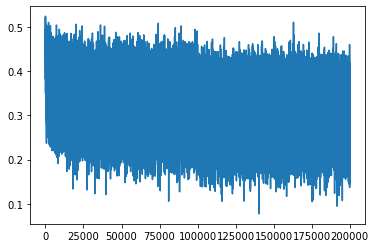

In [43]:
plt.plot(lossi)

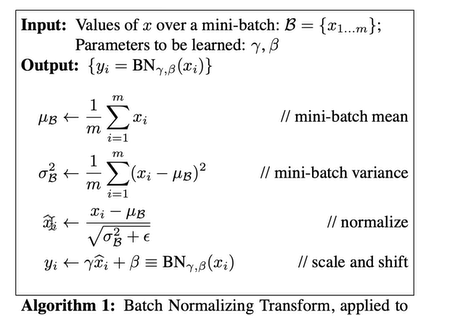

There is some funky stuff that happens when you have batches instead of single example. The normalization apply to all the examples in a batch. 

But what happens when you want to just put in one example, currently bgain is just for out batch/

In [44]:
with torch.no_grad():
    emb=C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@ W1+b1
    #measure the mean and std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [45]:
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val': (Xdev, Ydev),
           'test': (Xte, Yte),
          }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #Batch-norm
    
    #hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True)) + bnbias
    hpreact = bngain*(hpreact - bnmean / bnstd) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0459063053131104
val 2.108705997467041


but no one wants to do this because they are lazy. SO instead we are going to calculate like a running mean


# BatchNorm how it works on PyTorch



In [46]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# MLP
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)   
# 27x20 matrix -> each letter gets 10 numbers

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 

#the reason we have n_emb * block_size is because we want to concatinate the examples. Instead of a 3x10 matrix for one example
# I want to make it a 1x 30 matrix, each example in one row.

# dont use this bias because of the normalization 
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# the input into this layer is -> 1X200 
# this weight is 200 x 27 
# the output is 1x 27 vector which would be a probabilty of a letter out of the 27

b2 = torch.randn(vocab_size,                      generator=g) * 0



parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True
    

# at intialization the thing will be exactly unit gausssian


In [48]:
max_steps = 200000
batch_size = 32
lossi = []



for i in range(max_steps):
    # minibatch contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # its interesting that these are just 32 random example from the dataset. it is possible that some of the examples are not even in the training set???
    
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    # this is embeding each letter to a 1x10 vector
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # remember we what each example to be one row. this makes each example one row
    
    # forward pass:
    hpreact = embcat @ W1 + b1
    
    #Batch-norm
    # everysingle firing rate will be gaussian but we dont want all of them to be that way all the time, we want some neurons to be more "trigger happy"
    # depedning on the learning. So we introduce scale and shift
    
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    
    hpreact = bngain*(hpreact - bnmeani / bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    

    
    
    
    h = torch.tanh(hpreact) # activation is tanh
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
  
    
    

      0/ 200000: 3.3054
  10000/ 200000: 1.9723
  20000/ 200000: 1.9615
  30000/ 200000: 1.9927
  40000/ 200000: 2.2249
  50000/ 200000: 2.1427
  60000/ 200000: 2.0560
  70000/ 200000: 2.4045
  80000/ 200000: 2.4765
  90000/ 200000: 2.2469
 100000/ 200000: 2.2752
 110000/ 200000: 1.8618
 120000/ 200000: 2.1693
 130000/ 200000: 1.9158
 140000/ 200000: 1.7343
 150000/ 200000: 2.3178
 160000/ 200000: 2.2471
 170000/ 200000: 1.7665
 180000/ 200000: 1.8767
 190000/ 200000: 2.1175


In [49]:
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'val': (Xdev, Ydev),
           'test': (Xte, Yte),
          }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    #Batch-norm
    
    #hpreact = bngain*(hpreact - hpreact.mean(0,keepdim=True) / hpreact.std(0,keepdim=True)) + bnbias
    hpreact = bngain*(hpreact - bnmean_running / bnstd_running) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.046156644821167
val 2.109158515930176


the biases are not doing anything because you find the mean of hpreact. DOnt need bias but you can use batch normalization bias

its intresting how we are using normalization like we are assuming that that normaization is the distribution normally like height or something. i just thought that was interesting. The making of an "average" human